In [33]:
# import the usual
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from matplotlib.ticker import MaxNLocator

# put the two csv files into two distinct dataframes
df_attendance = pd.read_csv('attendance.csv')
df_games = pd.read_csv('games.csv')

# excluding the years that the league had less than 32 teams
excludeYears = [2000, 2001]

# Removes any rows containing a null value from the datasets
df_attendance = df_attendance[~df_attendance['year'].isin(excludeYears)]
df_attendance = df_attendance.dropna()
# dropping redundant values that could influence our results 
droppit = ['team', 'total', 'home', 'away']
df_attendance = df_attendance.drop(droppit, axis=1)
df_attendance.rename(columns={'team_name': 'home_team_name'}, inplace=True)
df_attendance['week'] = df_attendance['week'].astype(int)
df_attendance['weekly_attendance'] = df_attendance['weekly_attendance'].astype(int)

# this will allow us to merge the datasets
df_games = df_games[~df_games['year'].isin(excludeYears)]
droppa = ['home_team', 'away_team', 'tie', 'home_team_city', 'away_team_city']
exclude_weeks = ['WildCard', 'Division', 'ConfChamp', 'SuperBowl']
df_games = df_games.drop(droppa, axis=1)
df_games = df_games[~df_games['week'].isin(exclude_weeks)]
df_games = df_games.dropna()
df_games['week'] = df_games['week'].astype(int)

right = ['year', 'week', 'home_team_name']
df_result = df_attendance.merge(df_games, on=right)
to_convert_categorical = ['home_team_name', 'winner', 'day', 'away_team_name']
to_scale = ['year', 'week', 'pts_win', 'pts_loss', 'yds_win', 'turnovers_win', 'yds_loss', 'turnovers_loss']

df_result[to_convert_categorical] = df_result[to_convert_categorical].astype('category')
df_result = df_result.drop('date', axis=1)
df_result = df_result.drop('time', axis=1)

df_result_numerical = df_result.select_dtypes(include=[np.number])

correlation_matrix = df_result_numerical.corr()

df_result

,home_team_name,year,week,weekly_attendance,winner,day,pts_win,pts_loss,yds_win,turnovers_win,yds_loss,turnovers_loss,away_team_name
0,Cardinals,2002,3,28980,San Diego Chargers,Sun,23,15,289,1,297,3,Chargers
1,Cardinals,2002,4,30014,Arizona Cardinals,Sun,21,7,263,1,263,3,Giants
2,Cardinals,2002,7,59702,Arizona Cardinals,Sun,9,6,380,1,342,4,Cowboys
3,Cardinals,2002,9,47819,St. Louis Rams,Sun,27,14,415,2,235,3,Rams
4,Cardinals,2002,10,29252,Seattle Seahawks,Sun,27,6,406,0,337,5,Seahawks
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,Redskins,2019,7,61459,San Francisco 49ers,Sun,9,0,283,1,154,1,49ers
4604,Redskins,2019,11,56426,New York Jets,Sun,34,17,400,2,225,1,Jets
4605,Redskins,2019,12,57754,Washington Redskins,Sun,19,16,230,2,364,4,Lions
4606,Redskins,2019,15,63246,Philadelphia Eagles,Sun,37,27,415,1,352,1,Eagles


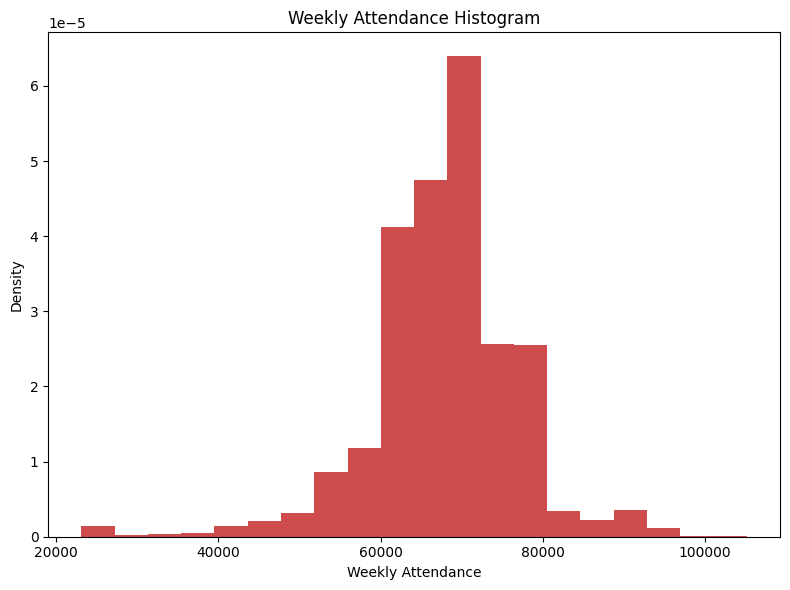

In [34]:
plt.figure(figsize=(8, 6))

# Plotting a histogram for the distribution of weekly attendance
plt.hist(df_result['weekly_attendance'], bins=20, density=True, alpha=0.7, color='#BB0000')

plt.xlabel('Weekly Attendance')
plt.ylabel('Density')
plt.title('Weekly Attendance Histogram')

plt.tight_layout()
plt.show()

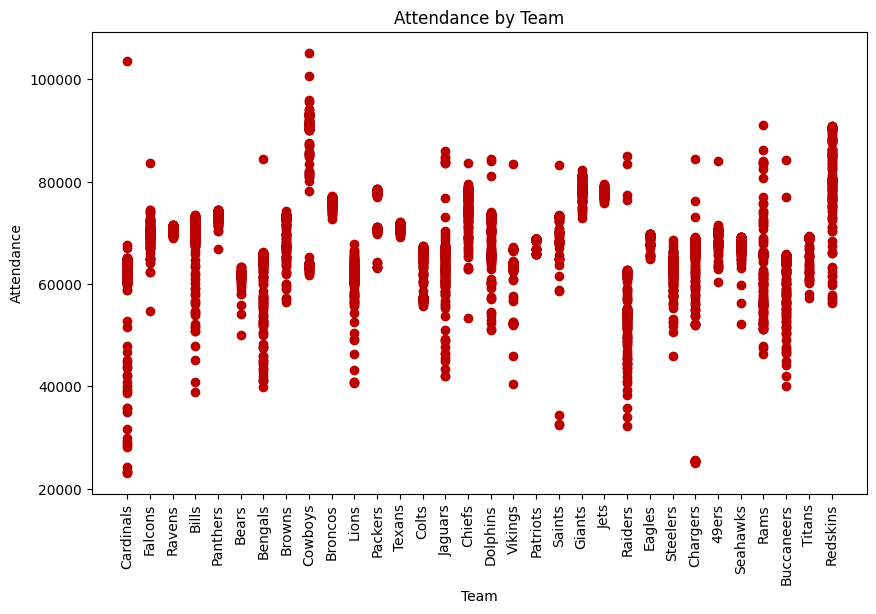

In [35]:
# Scatterplot for attendance on a team by team basis
plt.figure(figsize=(10,6))
plt.scatter(df_result['home_team_name'], df_result['weekly_attendance'], color='#BB0000')

plt.xlabel('Team')
plt.ylabel('Attendance')
plt.title('Attendance by Team')
plt.xticks(rotation=90)
plt.tight_layout

plt.show()

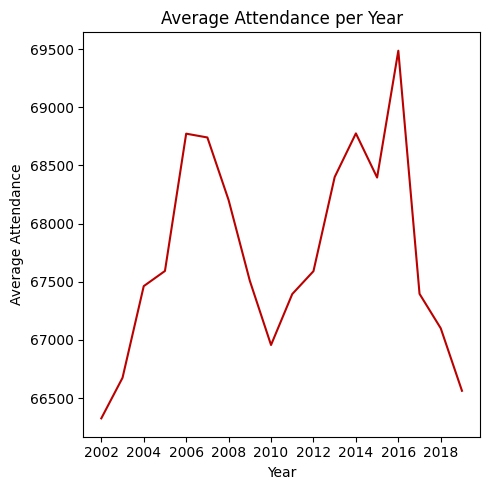

In [36]:
# League-wide average attendance from 2002 to 2019
avg_attendance_per_year = df_result.groupby('year')['weekly_attendance'].mean().reset_index()

plt.figure(figsize=(5, 5))
plt.plot(avg_attendance_per_year['year'], avg_attendance_per_year['weekly_attendance'], color='#BB0000')

plt.xlabel('Year')
plt.ylabel('Average Attendance')
plt.title('Average Attendance per Year')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

plt.show()

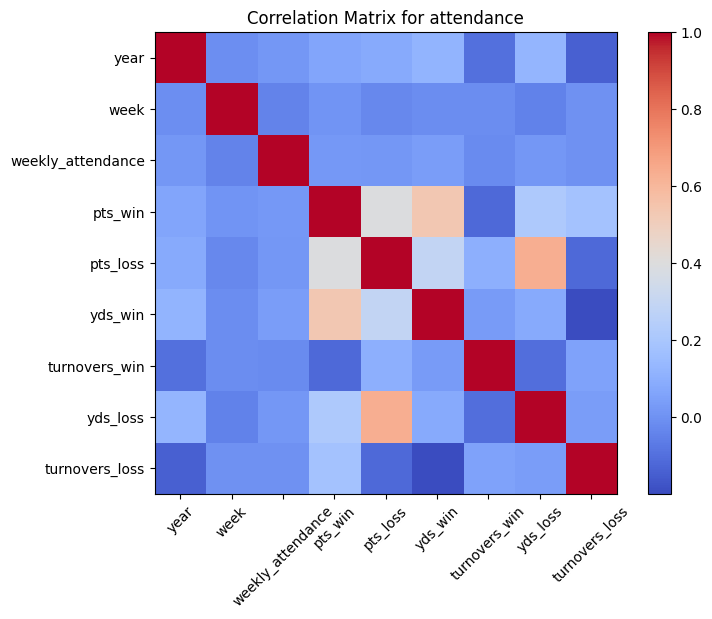

In [37]:
# This is showing ONLY the numerical values and how they correlate with one another
# The bluer, the less correlated. The redder, the more correlated...
# Note, the values down the diagonal are expected to be highly correlated, because it is comparing itself to itself
plt.figure(figsize=(8,6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.title("Correlation Matrix for attendance")
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.show()

In [38]:
X = df_result.drop('weekly_attendance', axis=1)
y = df_result['weekly_attendance']
# 80/20 split for training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [39]:
scaler = StandardScaler()

In [40]:
scaled_dfs_train = []
scaled_dfs_test = []
for col in to_scale:
    scaled_train = scaler.fit_transform(X_train[[col]])
    scaled_test = scaler.transform(X_test[[col]])
    scaled_dfs_train.append(pd.DataFrame(scaled_train, columns=scaler.get_feature_names_out([col])))
    scaled_dfs_test.append(pd.DataFrame(scaled_test, columns=scaler.get_feature_names_out([col])))

X_train_scaled = pd.concat([X_train.drop(columns=to_scale).reset_index(drop=True)] + scaled_dfs_train, axis=1)
X_test_scaled = pd.concat([X_test.drop(columns=to_scale).reset_index(drop=True)] + scaled_dfs_test, axis=1)

In [41]:
#converting our categorical data into 1s and 0s
# for the purposes of One-Hot Encoding, considering we cannot run
# categorical data through our models
encoded_dfs_train = []
encoded_dfs_test = []
for col in to_convert_categorical:
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_train = encoder.fit_transform(X_train_scaled[[col]])
    encoded_test = encoder.transform(X_test_scaled[[col]])
    encoded_dfs_train.append(pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out([col])))
    encoded_dfs_test.append(pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out([col])))

X_train_encoded = pd.concat([X_train_scaled.drop(columns=to_convert_categorical).reset_index(drop=True)] + encoded_dfs_train, axis=1)
X_test_encoded = pd.concat([X_test_scaled.drop(columns=to_convert_categorical).reset_index(drop=True)] + encoded_dfs_test, axis=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site

In [42]:
model = MLPRegressor()

In [43]:
param_grid = {
    'activation': ['identity', 'tanh', 'relu'],
    'hidden_layer_sizes': [(128), (128, 64), (128, 64, 32)],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 300, 400, 500]
}

In [44]:
scorer = make_scorer(r2_score, greater_is_better=True)

In [45]:
search = RandomizedSearchCV(model, param_grid, scoring=scorer, cv=3, n_iter=2)
grid_result = search.fit(X_train_encoded, y_train)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        24833     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32518D+09    |proj g|=  6.76239D+04

At iterate    1    f=  2.32504D+09    |proj g|=  6.76219D+04

At iterate    2    f=  8.16468D+07    |proj g|=  3.22698D+06
  ys=-1.144E+08  -gs= 1.067E+07 BFGS update SKIPPED

At iterate    3    f=  7.81797D+07    |proj g|=  3.77448D+06

At iterate    4    f=  7.02132D+07    |proj g|=  2.00926D+06

At iterate    5    f=  6.52197D+07    |proj g|=  1.81804D+06

At iterate    6    f=  3.29232D+07    |proj g|=  1.93974D+06

At iterate    7    f=  2.66014D+07    |proj g|=  1.25336D+06

At iterate    8    f=  2.48550D+07    |proj g|=  5.82477D+05

At iterate    9    f=  2.26327D+07    |proj g|=  3.98842D+05

At iterate   10    f=  2.11129D+07    |proj g|=  5.26572D+05

At iterate   11    f=  1.83303D+07    |proj g|=  6.05372D+05

At iterate   12    f=  1.79785D+07  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        24833     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33770D+09    |proj g|=  6.77510D+04

At iterate    1    f=  1.10672D+08    |proj g|=  7.07606D+06
  ys=-6.028E+08  -gs= 1.434E+07 BFGS update SKIPPED

At iterate    2    f=  8.74709D+07    |proj g|=  5.05885D+06

At iterate    3    f=  7.82747D+07    |proj g|=  2.44140D+06

At iterate    4    f=  7.16690D+07    |proj g|=  1.70711D+06

At iterate    5    f=  5.59126D+07    |proj g|=  2.85387D+06

At iterate    6    f=  3.73770D+07    |proj g|=  2.62572D+06

At iterate    7    f=  3.11428D+07    |proj g|=  2.78260D+06

At iterate    8    f=  2.74637D+07    |proj g|=  7.35531D+05

At iterate    9    f=  2.66969D+07    |proj g|=  5.80956D+05

At iterate   10    f=  2.47289D+07    |proj g|=  7.36236D+05

At iterate   11    f=  2.24113D+07    |proj g|=  7.68956D+05

At iterate   12    f=  2.00356D+07  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        24833     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32580D+09    |proj g|=  6.76341D+04

At iterate    1    f=  2.32568D+09    |proj g|=  6.76324D+04

At iterate    2    f=  9.08947D+07    |proj g|=  3.51722D+06
  ys=-3.227E+08  -gs= 8.433E+06 BFGS update SKIPPED

At iterate    3    f=  8.35474D+07    |proj g|=  3.45242D+06

At iterate    4    f=  7.39063D+07    |proj g|=  2.81048D+06

At iterate    5    f=  6.58299D+07    |proj g|=  1.70081D+06

At iterate    6    f=  5.59415D+07    |proj g|=  2.28697D+06

At iterate    7    f=  4.48395D+07    |proj g|=  2.24491D+06

At iterate    8    f=  2.85168D+07    |proj g|=  2.09106D+06

At iterate    9    f=  2.41965D+07    |proj g|=  1.41708D+06

At iterate   10    f=  2.25515D+07    |proj g|=  5.47393D+05

At iterate   11    f=  2.15507D+07    |proj g|=  3.88884D+05

At iterate   12    f=  2.02675D+07  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        24833     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32520D+09    |proj g|=  6.76243D+04

At iterate    1    f=  2.32493D+09    |proj g|=  8.59520D+04

At iterate    2    f=  2.24113D+09    |proj g|=  2.05300D+07

At iterate    3    f=  2.24093D+09    |proj g|=  2.16701D+07

At iterate    4    f=  8.79027D+07    |proj g|=  9.94166D+06

At iterate    5    f=  7.77854D+07    |proj g|=  1.86683D+07

At iterate    6    f=  7.11774D+07    |proj g|=  1.22023D+07

At iterate    7    f=  6.49747D+07    |proj g|=  6.84699D+06

At iterate    8    f=  5.49531D+07    |proj g|=  1.15817D+07

At iterate    9    f=  4.54370D+07    |proj g|=  2.19997D+07

At iterate   10    f=  3.28013D+07    |proj g|=  9.06727D+06

At iterate   11    f=  2.80627D+07    |proj g|=  4.45986D+06

At iterate   12    f=  2.63851D+07    |proj g|=  4.45709D+06

At iterate   13    f=  2.5

 This problem is unconstrained.



At iterate    1    f=  2.33634D+09    |proj g|=  5.11587D+05

At iterate    2    f=  9.15751D+07    |proj g|=  5.59033D+06
  ys=-4.844E+07  -gs= 4.351E+07 BFGS update SKIPPED

At iterate    3    f=  9.07762D+07    |proj g|=  6.62113D+06

At iterate    4    f=  8.67715D+07    |proj g|=  8.79147D+06

At iterate    5    f=  8.29552D+07    |proj g|=  4.03188D+06

At iterate    6    f=  7.89971D+07    |proj g|=  5.18300D+06

At iterate    7    f=  7.32405D+07    |proj g|=  2.30210D+06

At iterate    8    f=  5.88706D+07    |proj g|=  4.86140D+06

At iterate    9    f=  5.02234D+07    |proj g|=  1.07321D+07

At iterate   10    f=  4.14752D+07    |proj g|=  3.95103D+06

At iterate   11    f=  3.71627D+07    |proj g|=  3.30997D+06

At iterate   12    f=  3.22493D+07    |proj g|=  3.35042D+06

At iterate   13    f=  2.84244D+07    |proj g|=  1.59404D+06

At iterate   14    f=  2.76800D+07    |proj g|=  7.10164D+05

At iterate   15    f=  2.67773D+07    |proj g|=  1.75811D+06

At iterate   16  

 This problem is unconstrained.



At iterate    1    f=  8.77700D+07    |proj g|=  8.96754D+06

At iterate    2    f=  8.33400D+07    |proj g|=  2.80481D+06

At iterate    3    f=  7.30245D+07    |proj g|=  2.95056D+06

At iterate    4    f=  5.19390D+07    |proj g|=  5.50532D+06

At iterate    5    f=  3.73404D+07    |proj g|=  3.50710D+06

At iterate    6    f=  2.66908D+07    |proj g|=  2.36744D+06

At iterate    7    f=  2.58062D+07    |proj g|=  4.27239D+06

At iterate    8    f=  2.45455D+07    |proj g|=  9.40258D+05

At iterate    9    f=  2.42847D+07    |proj g|=  5.36260D+05

At iterate   10    f=  2.39638D+07    |proj g|=  5.84135D+05

At iterate   11    f=  2.29783D+07    |proj g|=  9.73507D+05

At iterate   12    f=  2.19499D+07    |proj g|=  1.44403D+06

At iterate   13    f=  2.16029D+07    |proj g|=  1.09038D+06

At iterate   14    f=  2.02080D+07    |proj g|=  1.46897D+06

At iterate   15    f=  1.94121D+07    |proj g|=  1.23472D+06

At iterate   16    f=  1.85946D+07    |proj g|=  3.51387D+05

At iter

 This problem is unconstrained.



At iterate    1    f=  2.21987D+09    |proj g|=  1.16314D+08

At iterate    2    f=  2.21555D+09    |proj g|=  1.47465D+08

At iterate    3    f=  9.33534D+08    |proj g|=  3.85551D+09

At iterate    4    f=  8.81588D+08    |proj g|=  4.99504D+09

At iterate    5    f=  2.26932D+08    |proj g|=  2.69716D+09

At iterate    6    f=  1.35967D+08    |proj g|=  7.13826D+08

At iterate    7    f=  1.28433D+08    |proj g|=  1.28636D+08

At iterate    8    f=  1.20650D+08    |proj g|=  5.96967D+07

At iterate    9    f=  1.09635D+08    |proj g|=  3.48311D+08

At iterate   10    f=  1.06146D+08    |proj g|=  3.99727D+08

At iterate   11    f=  9.98126D+07    |proj g|=  2.18809D+08

At iterate   12    f=  9.44231D+07    |proj g|=  1.22801D+08

At iterate   13    f=  9.06780D+07    |proj g|=  8.47400D+07

At iterate   14    f=  8.75126D+07    |proj g|=  1.33123D+07

At iterate   15    f=  8.64902D+07    |proj g|=  4.41452D+07

At iterate   16    f=  8.53408D+07    |proj g|=  6.98828D+07

At iter

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [46]:
best_params = grid_result.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'solver': 'lbfgs', 'max_iter': 400, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (128, 64, 32), 'alpha': 0.001, 'activation': 'identity'}


In [47]:
# we predict our values here using the test data
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test_encoded)

# in a nutshell, mse and mae should ideally be close to zero
# if not, then we have a significant amount of error the larger it gets
#Our R2 score should ideally be close to 1, meaning that our model is fairly accurate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error: ", mae)
print("R2 Score: ", r2_score)

Mean Squared Error: 35730856.47398274
Mean Absolute Error:  3740.033423522764
R2 Score:  0.5616268352115701


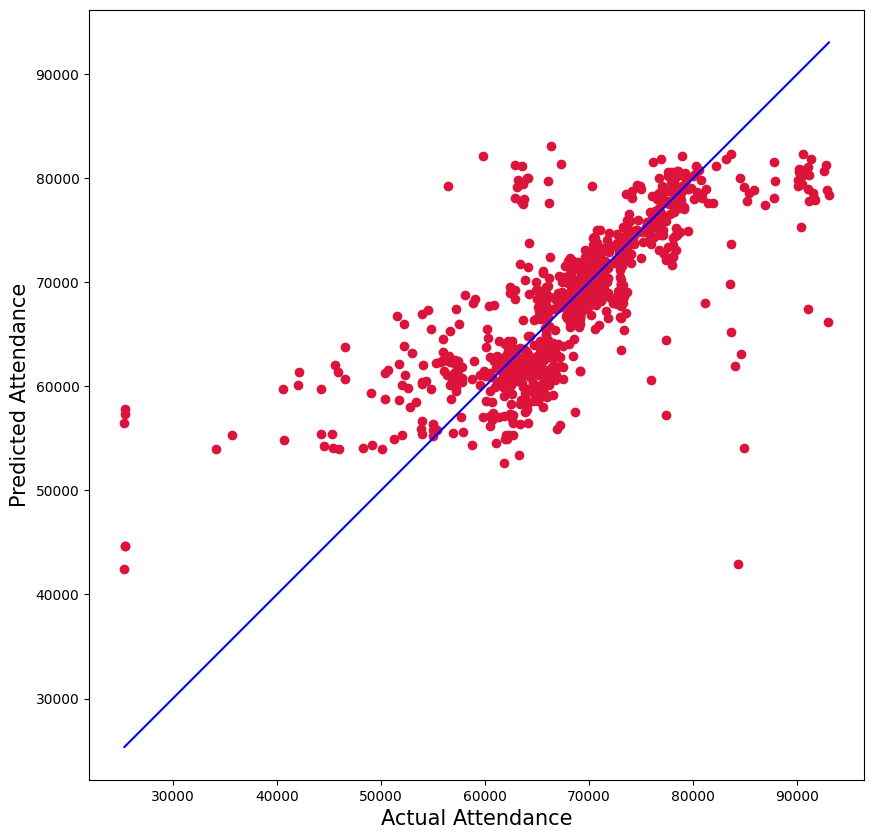

In [48]:
# Here, we print a scatter plot that shows us how our model performed
# the closer to the line, the more the model had accurately guessed the attendance
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Attendance', fontsize=15)
plt.ylabel('Predicted Attendance', fontsize=15)
plt.axis('equal')
plt.show()